# SuSIE results post process

This notebook is to post-process the susie results into different text file


### Extracting susie results

In [ ]:
sos run pipeline/SuSiE_post_processing.ipynb susie_to_tsv \
    --cwd output/test --rds_path `ls output/test/cache/*rds | head ` --region-list <(head -50  ./dlpfc_region_list) --container containers/stephenslab.sif 

### Extracting susie_rss results for ADGWAS

In [ ]:
sos run pipeline/SuSiE_post_processing.ipynb susie_to_tsv \
    --cwd output/ADGWAS_finemapping_extracted/Bellenguez/ --rds_path `ls GWAS_Finemapping_Results/Bellenguez/ADGWAS2022*rds ` \
    --region-list ~/1300_hg38_EUR_LD_blocks_orig.tsv \
    --container containers/stephenslab.sif 

sos run pipeline/SuSiE_post_processing.ipynb susie_tsv_collapse \
    --cwd output/ADGWAS_finemapping_extracted --tsv_path `ls output/ADGWAS_finemapping_extracted/*lbf.tsv` \
    --container containers/stephenslab.sif 

### Extracting fsusie results 

In [ ]:
sos run pipeline/SuSiE_post_processing.ipynb fsusie_to_tsv \
    --cwd output/f_susie_tad_haQTL_pos --rds_path `ls output/f_susie_tad_haQTL_pos/cache/*rds ` \
    --region-list ../eqtl/dlpfc_tad_list \
    --container containers/stephenslab.sif -s build

In [ ]:
sos run pipeline/SuSiE_post_processing.ipynb fsusie_to_tsv \
    --cwd output/f_susie_tad_meQTL_pos_selected/ --rds_path `ls output/f_susie_tad_meQTL_pos_selected//cache/*1204*rds ` \
    --region-list ../eqtl/dlpfc_tad_list \
    --container containers/stephenslab.sif -s build

In [ ]:
sos run pipeline/SuSiE_post_processing.ipynb fsusie_to_tsv \
    --cwd output/f_susie_tad_meQTL_pos_2/ --rds_path `ls output/f_susie_tad_meQTL_pos_2//cache/*rds ` \
    --region-list ../eqtl/dlpfc_tad_list \
    --container containers/stephenslab.sif -s build

In [ ]:
sos run pipeline/SuSiE_post_processing.ipynb fsusie_to_tsv \
    --cwd output/f_susie_tad_meQTL_pos/ --rds_path `ls output/f_susie_tad_meQTL_pos//cache/*rds ` \
    --region-list ../eqtl/dlpfc_tad_list \
    --container containers/stephenslab.sif -s build

In [ ]:
sos run pipeline/SuSiE_post_processing.ipynb fsusie_to_tsv \
    --cwd output/f_susie_tad_haQTL_pos_check_pure_2 --rds_path `ls output/f_susie_tad_haQTL_pos_check_pure_2/cache/*rds ` \
    --region-list ../eqtl/dlpfc_tad_list \
    --container containers/stephenslab.sif -s build

In [ ]:
sos run pipeline/SuSiE_post_processing.ipynb fsusie_to_tsv \
    --cwd output/f_susie_tad_meQTL_pos_2/ --rds_path `ls output/f_susie_tad_meQTL_pos_2//cache/*rds ` \
    --region-list ../eqtl/dlpfc_tad_list \
    --container containers/stephenslab.sif -s build

### Plotting the pip plot

In [ ]:
sos run pipeline/SuSiE_post_processing.ipynb susie_pip_landscape_plot \
    --cwd output/test/ --plot_list plot_recipe --annot_tibble ~/Annotatr_builtin_annotation_tibble.tsv -s force &

In [ ]:
sos run pipeline/SuSiE_post_processing.ipynb susie_upsetR_plot \
    --cwd output/test/ --plot_list plot_recipe_1  -s force &

The required input for this step is a tab-delimited plot_recipe file that specifies the path to each of the variant.tsv files generated from this module. Each column represents a molecular phenotype, and each row indicates the files that share common variants. Since one TAD may correspond to multiple genes, additional eQTL are permitted. If there are additional molecular phenotypes or ADGWAS datasets, additional columns can be appended.

The built-in Annotatr_builtin_annotation_tibble.tsv can be downloaded from [synapse](https://www.synapse.org/#!Synapse:syn51198526), please download it and specify the path.

In [3]:
cat /mnt/vast/hpc/csg/molecular_phenotype_calling/QTL_fine_mapping/plot_recipe

haQTL	mQTL	eQTL	eQTL	ADGWAS
/mnt/vast/hpc/csg/molecular_phenotype_calling/QTL_fine_mapping/output/f_susie_tad_meQTL_pos//meQTL.yuqi_mqtl.tad100.uni_Fsusie.mixture_normal_per_scale.variant.tsv	/mnt/vast/hpc/csg/molecular_phenotype_calling/QTL_fine_mapping/output/f_susie_tad_haQTL_pos//haQTL.rosmap_haqtl.tad100.uni_Fsusie.mixture_normal_per_scale.variant.tsv	/mnt/vast/hpc/csg/molecular_phenotype_calling/eqtl//output/susie_per_gene_tad//demo.ENSG00000117322.unisusie.fit.variant.tsv	/mnt/vast/hpc/csg/molecular_phenotype_calling/eqtl//output/susie_per_gene_tad//demo.ENSG00000203710.unisusie.fit.variant.tsv	/mnt/vast/hpc/csg/xqtl_workflow_testing/susie_rss/output/ADGWAS_finemapping_extracted/Bellenguez/ADGWAS2022.chr1.sumstat.chr1_205972031_208461272.unisusie_rss.fit.variant.tsv


In [ ]:
[global]
import glob
import pandas as pd


# A region list file documenting the chr_pos_ref_alt of a susie_object
parameter: cwd = path("output")
parameter: name = "demo"

## Path to work directory where output locates
## Containers that contains the necessary packages
parameter: container = ""
# For cluster jobs, number commands to run per job
parameter: job_size = 1
# Wall clock time expected
parameter: walltime = "96h"
# Memory expected
parameter: mem = "16G"
# Number of threads
parameter: numThreads = 20
parameter: windows = 1000000
# use this function to edit memory string for PLINK input
from sos.utils import expand_size

In [1]:
[susie_to_tsv_1]
# Input
# For complete susie, region_list or tad_list, for susie_rss , LD region list 
parameter: region_list = path
region_tbl = pd.read_csv(region_list,sep = "\t")
parameter: rds_path = paths
input: rds_path, group_by = 1
output: f"{cwd}/{_input:bn}.variant.tsv",f"{cwd}/{_input:bn}.lbf.tsv",f"{cwd}/{_input:bn}.effect.tsv"
task: trunk_workers = 1, trunk_size = job_size, walltime = walltime, mem = mem, cores = numThreads, tags = f'{step_name}_{_output[0]:bn}'
R: expand = '${ }', stdout = f"{_output[0]:nn}.stdout", stderr = f"{_output[0]:nn}.stderr", container = container
    library("dplyr")
    library("tibble")
    library("purrr")
    library("tidyr")
    library("readr")
    library("stringr")
    library("susieR")
    extract_lbf = function(susie_obj){
    
    if("variants" %in% names(susie_obj) ){
    ss_bf = tibble(snps = susie_obj$variants, cs_index = ifelse(is.null(susie_obj$sets$cs_index), 0, paste0(susie_obj$sets$cs_index,collapse =",")),names = "${f'{_input:br}'.split('.')[-4]}")
    }
      else 
      {
    ss_bf = tibble(snps = susie_obj$variable_name, cs_index = ifelse(is.null(susie_obj$sets$cs_index), 0, paste0(susie_obj$sets$cs_index,collapse =",")),names = "${_input:bnnn}")
     }
    
    ss_bf = ss_bf%>%cbind(susie_obj$lbf_variable%>%t)%>%as_tibble()
    
    return(ss_bf)
    }
    
    extract_variants_pip = function(susie_obj,region_list){
    susie_tb = tibble( variants =  names(susie_obj$pip)[which( susie_obj$pip >= 0)],
                           snps_index = which(( susie_obj$pip >= 0))) %>%
        mutate(chromosome = map_chr(variants, ~read.table(text = .x, sep = ":")$V1%>%str_replace("chr","") ),
                position  = map_chr(variants, ~read.table(text = .x, sep = ":")$V2  ),
                ref = map_chr(position , ~read.table(text = .x, sep = "_",colClasses = "character")$V2  ),
                alt = map_chr(position , ~read.table(text = .x, sep = "_",colClasses = "character")$V3  ),
                position  = map_dbl(position , ~read.table(text = .x, sep = "_",as.is = T)$V1  )
                             )
      susie_tb = susie_tb%>%mutate(cs_order =(map(susie_tb$snps_index , ~tryCatch(which(pmap(list( a= susie_obj$sets$cs) , function(a) .x %in% a )%>%unlist()), error = function(e) return(0) )  ))%>%as.character%>%str_replace("integer\\(0\\)","0"),
                         cs_id = map_chr(cs_order,~ifelse(.x =="0", "None" ,names(susie_obj$sets$cs)[.x%>%str_split(":")%>%unlist%>%as.numeric] ) ),
                         log10_base_factor = map_chr(snps_index,~paste0( susie_obj$lbf_variable[,.x],  collapse = ";")),
                         pip = susie_obj$pip,
                         posterior_mean = coef.susie(susie_obj)[-1],
                         posterior_sd = susie_get_posterior_sd(susie_obj),
                         z = posterior_mean/posterior_sd)
    
          susie_tb =  susie_tb%>%mutate(  molecular_trait_id = region_list$molecular_trait_id,
                             finemapped_region_start = region_list$finemapped_region_start,
                             finemapped_region_end = region_list$finemapped_region_end)
          return(susie_tb)    }
          
        

     extract_effect_pip = function(susie_obj,region_list,susie_tb){
      result_tb =  tibble(phenotype = susie_obj$name,
        V = susie_obj$V,effect_id = paste0("L",1:length(V) ) ,
        cs_log10bf = susie_obj$lbf)
        if(is.null(susie_obj$sets$cs)){
            cs_min_r2 = cs_avg_r2 =  coverage =  0 
            cs = "None"} else {         cs = map_chr(susie_obj$sets$cs[result_tb$effect_id],~susie_tb$variants[.x]%>%paste0(collapse = ";"))
        coverage = map(result_tb$effect_id, ~susie_obj$sets$coverage[which(names(susie_obj$sets$cs) == .x )])%>%as.numeric%>%replace_na(0)
        cs_min_r2  = (susie_obj$sets$purity[result_tb$effect_id,1])%>%as.numeric%>%replace_na(0)  
        cs_avg_r2  = (susie_obj$sets$purity[result_tb$effect_id,2])%>%as.numeric%>%replace_na(0) }
        result_tb = result_tb%>%mutate(cs_min_r2 = cs_min_r2,cs_avg_r2 = cs_avg_r2 ,coverage = coverage%>%unlist,cs = cs )            
      return(result_tb)
      }
       
  
    susie_obj = readRDS("${_input:a}")
    if("variants" %in% names(susie_obj) ){susie_obj$variants = susie_obj$variants%>%str_replace("_",":")}
    if(is.null(names(susie_obj$pip ))){names(susie_obj$pip) = susie_obj$variants}
    lbf = extract_lbf(susie_obj)
    region_list = read_delim("${region_list}","\t")
    if(ncol(region_list) == 3 ){   region_list =  region_list%>%mutate(`#chr` = `#chr`%>%str_remove_all(" ") , ID = paste0(`#chr`,"_",start,"_",end) ) } # LD_list 
    if(region_list$start[1] - region_list$end[1]  == -1 ){ 
        region_list = region_list%>%mutate( start = start - ${windows} ,end = start +${windows}) # region_list for fix cis windows  
          } 
      if("gene_id" %in% colnames(region_list)){region_list = region_list%>%mutate(ID = gene_id)  } # region_list for gene
    region_list = region_list%>%select(molecular_trait_id = ID, chromosome  = `#chr`,finemapped_region_start = start ,finemapped_region_end = end)  # Formatting
    region_list = region_list%>%filter(molecular_trait_id == "${f'{_input:br}'.split('.')[-4]}")
    variants_pip = extract_variants_pip( susie_obj , region_list)
    effect_pip = extract_effect_pip( susie_obj , region_list,variants_pip)
    lbf%>%write_delim("${_output[1]}","\t")
    variants_pip%>%write_delim("${_output[0]}","\t")
    effect_pip%>%write_delim("${_output[2]}","\t")

In [ ]:
[fsusie_to_tsv_1]
# Input
# For complete susie, region_list or tad_list, for susie_rss , LD region list 
parameter: region_list = path
region_tbl = pd.read_csv(region_list,sep = "\t")
parameter: rds_path = paths
input: rds_path, group_by = 1
output: f"{cwd}/{_input:bn}.variant.tsv"
task: trunk_workers = 1, trunk_size = job_size, walltime = walltime, mem = mem, cores = numThreads, tags = f'{step_name}_{_output[0]:bn}'
R: expand = '${ }', stdout = f"{_output[0]:nn}.stdout", stderr = f"{_output[0]:nn}.stderr", container = container
    library("dplyr")
    library("tibble")
    library("purrr")
    library("tidyr")
    library("readr")
    library("stringr")
    library("susieR")

    extract_variants_pip = function(susie_obj,region_list){
        susie_tb = tibble( variants =  names(susie_obj$csd_X),
                               snps_index = which(( susie_obj$pip >= 0))) %>%
            mutate(chromosome = map_chr(variants, ~read.table(text = .x, sep = ":")$V1%>%str_replace("chr","") ),
                    position  = map_chr(variants, ~read.table(text = .x, sep = ":")$V2  ),
                    ref = map_chr(position , ~read.table(text = .x, sep = "_",colClasses = "character")$V2  ),
                    alt = map_chr(position , ~read.table(text = .x, sep = "_",colClasses = "character")$V3  ),
                    position  = map_dbl(position , ~read.table(text = .x, sep = "_",as.is = T)$V1  )
                                 )
          susie_tb = susie_tb%>%mutate(cs_order =(map(susie_tb$snps_index , ~tryCatch(which(pmap(list( a= susie_obj$cs) , function(a) .x %in% a )%>%unlist()), error = function(e) return(0) )  ))%>%as.character%>%str_replace("integer\\(0\\)","0"),
                             pip = susie_obj$pip)
          susie_tb =  susie_tb%>%mutate(  molecular_trait_id = region_list$tad_index,
                                 finemapped_region_start = region_list$start,
                                 finemapped_region_end = region_list$end)
          if("purity" %in% names(susie_obj)){
              susie_tb = susie_tb%>%mutate(purity = map_dbl(susie_tb$cs_order, ~ifelse(.x%>%as.numeric > 0, susie_obj$purity[[as.numeric(.x)]], NA ) ), is_dummy = as.numeric(purity < 0.5)  )
              }
    susie_tb = cbind(susie_tb,Reduce(cbind, susie_obj$lBF)%>%as.tibble%>%`colnames<-`(1:length(susie_obj$lBF)))
          return(susie_tb)    }
    susie_obj = readRDS("${_input:a}")
    region_list = read_delim("${region_list}","\t")
    region_list = region_list%>%filter(tad_index == "${f'{_input:br}'.split('.')[-4]}")
    variants_pip = extract_variants_pip( susie_obj , region_list)
    print(paste0("fsusie run time is ", round(susie_obj$runtime[[3]]/60),"min"))
    variants_pip%>%write_delim("${_output}","\t")

In [ ]:
[*_to_tsv_2]
parameter: name = f'{_input[0]:b}'.split(".")[0]
input: group_by = "all"
output: f"{cwd}/{name}.all_variants.tsv"
bash: expand = '${ }', stdout = f"{_output:n}.stdout", stderr = f"{_output:n}.stderr", container = container
    head -1 ${_input[0]} > ${_output}
    cat ${_input[0]:d}/*variant.tsv | grep -v cs_order >> ${_output}

In [ ]:
[susie_tsv_collapse]
parameter: tsv_path = paths # TSV needs have the name ends with  *.chr1_2_3.unisusie(_rss).lbf.tsv
tsv_list  = pd.DataFrame({"lbf_path" : [str(x) for x in tsv_path]})
chromosome = list(set([f'{x.split(".")[-5].split("_")[0].replace("chr","")}'  for x in tsv_list.lbf_path ])) ## Add chr if there is no chr prefix. This is to accomodata chr XY and M
input: tsv_path, for_each = "chromosome"
output: f'{cwd}/{_input[0]:bnnnnnnn}.chr{_chromosome}.unisusie_rss.lbf.tsv'
bash: expand = '${ }', stdout = f"{_output}.stdout", stderr = f"{_output}.stderr", container = container
        head -1 ${_input[0]} > ${_output}
        cat ${_input[0]:d}/*.chr${_chromosome}_*lbf.tsv | grep -v cs_index >> ${_output}
        

In [ ]:
[susie_pip_landscape_plot]
parameter: plot_list = path
parameter: annot_tibble = path
import pandas as pd
plot_list  = pd.read_csv(plot_list,"\t")
file_type = plot_list.columns.values.tolist()
file_type = [x.split(".")[0] for x in file_type ]
plot_list = plot_list.to_dict("records")
input: plot_list, group_by = len(file_type)
output: f'{cwd}/{"_".join(file_type)}.{str(_input[0]).split(".")[-5]}.pip_landscape_plot.rds',f'{cwd}/{"_".join(file_type)}.{str(_input[0]).split(".")[-5]}.pip_landscape_plot.pdf'
R: expand = '${ }', stdout = f"{_output[0]}.stdout", stderr = f"{_output[0]}.stderr", container = container
    library("dplyr")
    library("readr") 
    library("ggplot2")
    library("purrr")
    color = c("black", "dodgerblue2", "green4", "#6A3D9A", 
          "#FF7F00", "gold1", "skyblue2", "#FB9A99", "palegreen2",
          "#CAB2D6", "#FDBF6F", "gray70", "khaki2", "maroon", "orchid1",
          "deeppink1", "blue1", "steelblue4", "darkturquoise", "green1", 
          "yellow4", "yellow3","darkorange4","brown","navyblue","#FF0000",
          "darkgreen","#FFFF00","purple","#00FF00","pink","#0000FF",
          "orange","#FF00FF","cyan","#00FFFF","#FFFFFF")
    extract_table = function(variant_df,type){ 
    if("is_dummy" %in% colnames(variant_df) ){
      variant_df$is_dummy[is.na(variant_df$is_dummy)] = 0
      variant_df[variant_df$is_dummy == 1,7] = 0
      }
     variant_df = variant_df%>%mutate(CS = (cs_order%>%as.factor%>%as.numeric-1)%>%as.factor)%>%
          select( y = pip ,snp = variants,pos = position , CS, molecular_trait_id)%>%mutate(molecular_trait_id = paste0(type,"_",molecular_trait_id ) )
    return(variant_df)
    }
    plot_recipe = tibble( type =  c('${"','".join(file_type) }'), path = c(${_input:r,}))
    plot_list = map2(plot_recipe$type,plot_recipe$path, ~read_delim(.y, guess_max = 10000000)%>%extract_table(.x) )
    plot_df = Reduce(rbind,plot_list)
    plot_range = (plot_df%>%group_by(molecular_trait_id)%>%summarize(start = (min(pos)), end = (max(pos)))%>%mutate(start = median(start),end = median(end)))[1,c(2,3)]%>%as.matrix
    plot_chr = (plot_df$snp[1]%>%stringr::str_split(":"))[[1]][1]
    plot_df = plot_df%>%mutate(Shared = as.logical(map(snp, ~(plot_df%>%filter( snp ==.x ,   CS%>%as.numeric !=  1 )%>%nrow()) > 1  )))
    pip_plot <- plot_df%>%ggplot2::ggplot(aes(y = y, x = pos,
                                  col =  CS, shape = Shared )) + facet_grid(molecular_trait_id ~.)+
      geom_point(size = 7) +
      scale_color_manual("Gene",values = color) +
      theme(axis.ticks.x = element_blank()) +
     ylab("Posterior Inclusion Probability (PIP)")+xlim(plot_range)+
      theme(axis.ticks.x = element_blank()) +
            theme(strip.text.y.right = element_text(angle = 0))+
            xlab("") + 
            theme(text = element_text(size = 30))+ggtitle("Overview of fine-mapping")
  
    annot = read_delim("${annot_tibble}")
    annot = annot%>%filter(seqnames == plot_chr, start > plot_range[1], end < plot_range[2])
    annot_plot   = annot%>%filter(!type%in%c("hg38_genes_introns","hg38_genes_1to5kb"))%>%
                        ggplot(aes())+
                        geom_segment( aes(x = start,xend = end, y = "Regulartory Element", yend = "Regulartory Element", color = type ), linewidth =10)+
                        ylab("")+xlab("")+xlim(plot_range)+theme(axis.text.x=element_blank(),text = element_text(size = 20))+scale_color_brewer(palette="Dark2")
    gene_plot = annot%>%filter(type%in%c("hg38_genes_1to5kb"))%>%group_by(symbol)%>%
                            summarise(start = min(start), end = max(end))%>%na.omit%>%
                            ggplot(aes())+geom_segment( aes(x = start,xend = end, y = "Gene", yend = "Gene", color = symbol ), linewidth =10)+
                            geom_label(aes(x = (start+end)/2,y = "Gene", label = symbol ),size = 5)+ylab("")+xlab("POS")+
                            theme(legend.position="none")+theme(text = element_text(size = 20))+xlim(plot_range)
      
    list(pip_plot,plot_df,annot_plot,gene_plot)%>%saveRDS("${_output[0]}")
    cowplot::plot_grid(plotlist = list(pip_plot,annot_plot,gene_plot),ncol = 1, align = "v",axis = "tlbr",rel_heights = c(8,1,1))%>%ggsave(filename = "${_output[1]}",device = "pdf",dpi = "retina",width = 30, height = 30)

In [2]:
library("dplyr")
library("readr")
library("ggplot2")
library("purrr")
color = c("black", "dodgerblue2", "green4", "#6A3D9A",
      "#FF7F00", "gold1", "skyblue2", "#FB9A99", "palegreen2",
      "#CAB2D6", "#FDBF6F", "gray70", "khaki2", "maroon", "orchid1",
      "deeppink1", "blue1", "steelblue4", "darkturquoise", "green1",
      "yellow4", "yellow3","darkorange4","brown","navyblue","#FF0000",
      "darkgreen","#FFFF00","purple","#00FF00","pink","#0000FF",
      "orange","#FF00FF","cyan","#00FFFF","#FFFFFF")
extract_table = function(variant_df,type){
if("is_dummy" %in% colnames(variant_df) ){
  variant_df$is_dummy[is.na(variant_df$is_dummy)] = 0
  variant_df[variant_df$is_dummy == 1,7] = 0
  }
 variant_df = variant_df%>%mutate(CS = (cs_order%>%as.factor%>%as.numeric-1)%>%as.factor)%>%
      select( y = pip ,snp = variants,pos = position , CS, molecular_trait_id)%>%mutate(molecular_trait_id = paste0(type,"_",molecular_trait_id ) )
return(variant_df)
}


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
plot_recipe = tibble( type =  c('eQTL','sQTL_MXE','pQTL'), path = c('/mnt/vast/hpc/csg/molecular_phenotype_calling/eqtl/output/susie_per_gene_tad/demo.ENSG00000085788.unisusie.fit.variant.tsv','/mnt/vast/hpc/csg/molecular_phenotype_calling/sQTL_finemapping/ROSMAP_psichomics/psi_MXE/output/test/demo.psichomics_sQTL.MXE_8_ENSG00000085788.unisusie.fit.variant.tsv','/mnt/vast/hpc/csg/molecular_phenotype_calling/pqtl_finemapping/output/susie_per_ID_tad/cache/result/demo.pqtl.8_DDHD2_O94830.unisusie.fit.variant.tsv'))
plot_list = map2(plot_recipe$type,plot_recipe$path, ~read_delim(.y, guess_max = 10000000)%>%extract_table(.x) )

Rows: 1994 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (7): variants, ref, alt, cs_order, cs_id, log10_base_factor, molecular_t...
dbl (9): snps_index, chromosome, position, pip, posterior_mean, posterior_sd...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1994 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (7): variants, ref, alt, cs_order, cs_id, log10_base_factor, molecular_t...
dbl (9): snps_index, chromosome, position, pip, posterior_mean, posterior_sd...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1994 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (7): v

In [21]:
plot_df = Reduce(rbind,plot_list)
plot_range = (plot_df%>%group_by(molecular_trait_id)%>%summarize(start = (min(pos)), end = (max(pos)))%>%mutate(start = median(start),end = median(end)))[1,c(2,3)]%>%as.matrix

In [22]:
plot_chr = (plot_df$snp[1]%>%stringr::str_split(":"))[[1]][1]
plot_df = plot_df%>%mutate(Shared = as.logical(map(snp, ~(plot_df%>%filter( snp ==.x ,   CS%>%as.numeric !=  1 )%>%nrow()) > 1  )))

In [23]:
head(plot_df)

y,snp,pos,CS,molecular_trait_id,Shared
<dbl>,<chr>,<dbl>,<fct>,<chr>,<lgl>
2.818856e-13,chr8:38120214_T_G,38120214,0,eQTL_ENSG00000085788,FALSE
1.532108e-14,chr8:38121338_TATATATATATA_TTA,38121338,0,eQTL_ENSG00000085788,FALSE
1.554312e-14,chr8:38122143_A_G,38122143,0,eQTL_ENSG00000085788,FALSE
3.732570e-13,chr8:38123069_A_C,38123069,0,eQTL_ENSG00000085788,FALSE
2.033596e-12,chr8:38125608_CAAA_CA,38125608,0,eQTL_ENSG00000085788,FALSE
1.807443e-13,chr8:38125608_CAAA_CAA,38125608,0,eQTL_ENSG00000085788,FALSE


In [24]:
plot_df$molecular_trait_id[plot_df$molecular_trait_id == "sQTL_MXE_MXE_8_+_38237627_38238089_38238209_38240275_38240364_38242250_ENSG00000085788"] <- "sQTL_MXE_8_ENSG00000085788"

In [25]:
pip_plot <- plot_df%>%ggplot2::ggplot(aes(y = y, x = pos,
                              col =  CS, shape = Shared )) + facet_grid(molecular_trait_id ~.)+
  geom_point(size = 7) +
  scale_color_manual("Gene",values = color) +
  theme(axis.ticks.x = element_blank()) +
 ylab("Posterior Inclusion Probability (PIP)")+xlim(plot_range)+
  theme(axis.ticks.x = element_blank()) +
        theme(strip.text.y.right = element_text(angle = 0))+
        xlab("") +
        theme(text = element_text(size = 30))+ggtitle("Overview of fine-mapping")

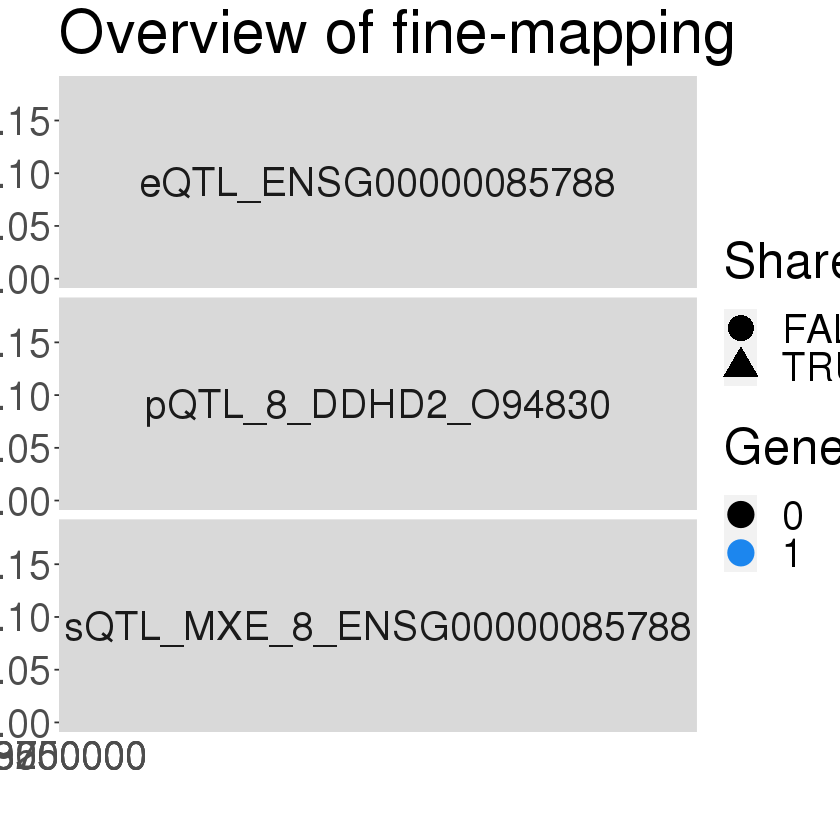

In [26]:
pip_plot

In [27]:
annot = read_delim("/mnt/mfs/hgrcgrid/homes/hs3163/Annotatr_builtin_annotation_tibble.tsv")
annot = annot%>%filter(seqnames == plot_chr, start > plot_range[1], end < plot_range[2])
annot_plot   = annot%>%filter(!type%in%c("hg38_genes_introns","hg38_genes_1to5kb"))%>%
                    ggplot(aes())+
                    geom_segment( aes(x = start,xend = end, y = "Regulartory Element", yend = "Regulartory Element", color = type ), linewidth =10)+
                    ylab("")+xlab("")+xlim(plot_range)+theme(axis.text.x=element_blank(),text = element_text(size = 20))+scale_color_brewer(palette="Dark2")
gene_plot = annot%>%filter(type%in%c("hg38_genes_1to5kb"))%>%group_by(symbol)%>%
                        summarise(start = min(start), end = max(end))%>%na.omit%>%
                        ggplot(aes())+geom_segment( aes(x = start,xend = end, y = "Gene", yend = "Gene", color = symbol ), linewidth =10)+
                        geom_label(aes(x = (start+end)/2,y = "Gene", label = symbol ),size = 5)+ylab("")+xlab("POS")+
                        theme(legend.position="none")+theme(text = element_text(size = 20))+xlim(plot_range)

list(pip_plot,plot_df,annot_plot,gene_plot)%>%saveRDS("/mnt/vast/hpc/csg/molecular_phenotype_calling/sQTL_finemapping/ROSMAP_psichomics/psi_MXE/Plot/eQTL_sQTL_MXE_pQTL.ENSG00000085788.pip_landscape_plot.rds")
cowplot::plot_grid(plotlist = list(pip_plot,annot_plot,gene_plot),ncol = 1, align = "v",axis = "tlbr",rel_heights = c(8,1,1))%>%ggsave(filename = "/mnt/vast/hpc/csg/molecular_phenotype_calling/sQTL_finemapping/ROSMAP_psichomics/psi_MXE/Plot/eQTL_sQTL_MXE_pQTL.ENSG00000085788.pip_landscape_plot.pdf",device = "pdf",dpi = "retina",width = 30, height = 30)

Rows: 3675002 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): seqnames, strand, id, tx_id, symbol, type
dbl (4): start, end, width, gene_id

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“Ignoring unknown parameters: linewidth”
Warning message:
“Ignoring unknown parameters: linewidth”


In [ ]:
library("dplyr")
library("readr")
library("ggplot2")
library("purrr")
color = c("black", "dodgerblue2", "green4", "#6A3D9A",
      "#FF7F00", "gold1", "skyblue2", "#FB9A99", "palegreen2",
      "#CAB2D6", "#FDBF6F", "gray70", "khaki2", "maroon", "orchid1",
      "deeppink1", "blue1", "steelblue4", "darkturquoise", "green1",
      "yellow4", "yellow3","darkorange4","brown","navyblue","#FF0000",
      "darkgreen","#FFFF00","purple","#00FF00","pink","#0000FF",
      "orange","#FF00FF","cyan","#00FFFF","#FFFFFF")
extract_table = function(variant_df,type){
if("is_dummy" %in% colnames(variant_df) ){
  variant_df$is_dummy[is.na(variant_df$is_dummy)] = 0
  variant_df[variant_df$is_dummy == 1,7] = 0
  }
 variant_df = variant_df%>%mutate(CS = (cs_order%>%as.factor%>%as.numeric-1)%>%as.factor)%>%
      select( y = pip ,snp = variants,pos = position , CS, molecular_trait_id)%>%mutate(molecular_trait_id = paste0(type,"_",molecular_trait_id ) )
return(variant_df)
}
plot_recipe = tibble( type =  c('eQTL','sQTL_MXE','pQTL'), path = c('/mnt/vast/hpc/csg/molecular_phenotype_calling/eqtl/output/susie_per_gene_tad/demo.ENSG00000085788.unisusie.fit.variant.tsv','/mnt/vast/hpc/csg/molecular_phenotype_calling/sQTL_finemapping/ROSMAP_psichomics/psi_MXE/output/test/demo.psichomics_sQTL.MXE_8_ENSG00000085788.unisusie.fit.variant.tsv','/mnt/vast/hpc/csg/molecular_phenotype_calling/pqtl_finemapping/output/susie_per_ID_tad/cache/result/demo.pqtl.8_DDHD2_O94830.unisusie.fit.variant.tsv'))
plot_list = map2(plot_recipe$type,plot_recipe$path, ~read_delim(.y, guess_max = 10000000)%>%extract_table(.x) )
plot_df = Reduce(rbind,plot_list)
plot_range = (plot_df%>%group_by(molecular_trait_id)%>%summarize(start = (min(pos)), end = (max(pos)))%>%mutate(start = median(start),end = median(end)))[1,c(2,3)]%>%as.matrix
plot_chr = (plot_df$snp[1]%>%stringr::str_split(":"))[[1]][1]
plot_df = plot_df%>%mutate(Shared = as.logical(map(snp, ~(plot_df%>%filter( snp ==.x ,   CS%>%as.numeric !=  1 )%>%nrow()) > 1  )))
pip_plot <- plot_df%>%ggplot2::ggplot(aes(y = y, x = pos,
                              col =  CS, shape = Shared )) + facet_grid(molecular_trait_id ~.)+
  geom_point(size = 7) +
  scale_color_manual("Gene",values = color) +
  theme(axis.ticks.x = element_blank()) +
 ylab("Posterior Inclusion Probability (PIP)")+xlim(plot_range)+
  theme(axis.ticks.x = element_blank()) +
        theme(strip.text.y.right = element_text(angle = 0))+
        xlab("") +
        theme(text = element_text(size = 30))+ggtitle("Overview of fine-mapping")

annot = read_delim("/mnt/mfs/hgrcgrid/homes/hs3163/Annotatr_builtin_annotation_tibble.tsv")
annot = annot%>%filter(seqnames == plot_chr, start > plot_range[1], end < plot_range[2])
annot_plot   = annot%>%filter(!type%in%c("hg38_genes_introns","hg38_genes_1to5kb"))%>%
                    ggplot(aes())+
                    geom_segment( aes(x = start,xend = end, y = "Regulartory Element", yend = "Regulartory Element", color = type ), linewidth =10)+
                    ylab("")+xlab("")+xlim(plot_range)+theme(axis.text.x=element_blank(),text = element_text(size = 20))+scale_color_brewer(palette="Dark2")
gene_plot = annot%>%filter(type%in%c("hg38_genes_1to5kb"))%>%group_by(symbol)%>%
                        summarise(start = min(start), end = max(end))%>%na.omit%>%
                        ggplot(aes())+geom_segment( aes(x = start,xend = end, y = "Gene", yend = "Gene", color = symbol ), linewidth =10)+
                        geom_label(aes(x = (start+end)/2,y = "Gene", label = symbol ),size = 5)+ylab("")+xlab("POS")+
                        theme(legend.position="none")+theme(text = element_text(size = 20))+xlim(plot_range)

list(pip_plot,plot_df,annot_plot,gene_plot)%>%saveRDS("/mnt/vast/hpc/csg/molecular_phenotype_calling/sQTL_finemapping/ROSMAP_psichomics/psi_MXE/Plot/eQTL_sQTL_MXE_pQTL.ENSG00000085788.pip_landscape_plot.rds")
cowplot::plot_grid(plotlist = list(pip_plot,annot_plot,gene_plot),ncol = 1, align = "v",axis = "tlbr",rel_heights = c(8,1,1))%>%ggsave(filename = "/mnt/vast/hpc/csg/molecular_phenotype_calling/sQTL_finemapping/ROSMAP_psichomics/psi_MXE/Plot/eQTL_sQTL_MXE_pQTL.ENSG00000085788.pip_landscape_plot.pdf",device = "pdf",dpi = "retina",width = 30, height = 30)

In [1]:
[susie_upsetR_plot]
parameter: plot_list = path
import pandas as pd
plot_list  = pd.read_csv(plot_list,"\t")
file_type = plot_list.columns.values.tolist()
file_type = [x.split(".")[0] for x in file_type ]
plot_list = plot_list.to_dict("records")
input: plot_list
output: f'{cwd}/{"_".join(file_type)}.UpSetR.rds',f'{cwd}/{"_".join(file_type)}.UpSetR.pdf'
R: expand = '${ }', stdout = f"{_output[0]}.stdout", stderr = f"{_output[0]}.stderr", container = container
    library("dplyr")
    library("readr") 
    library("ggplot2")
    library("purrr")
    library("UpSetR")
    library("ComplexUpset")
    plot_recipe = tibble( type =  c('${"','".join(file_type) }'), path = c(${_input:r,}))
    plot_list = map2(plot_recipe$type,plot_recipe$path, ~read_delim(.y, guess_max = 10000000)%>%mutate(cs = cs_order != 0 )%>%filter(cs > 0)%>%select(variants,cs)%>%`colnames<-`(c("variants",.x))%>%distinct() )
    cs_sharing = Reduce(full_join,plot_list)
    cs_upsetR_sharing = cs_sharing
    cs_upsetR_sharing[,2:ncol(cs_upsetR_sharing)]%>%mutate_all(as.numeric)-> cs_upsetR_sharing[,2:ncol(cs_upsetR_sharing)]
    a = upset(cs_upsetR_sharing%>%as.data.frame,intersect = colnames(cs_upsetR_sharing[2:ncol(cs_upsetR_sharing)]),
      keep_empty_groups = F,
          base_annotations=list(`Intersection size` = intersection_size( bar_number_threshold = 1, position = position_dodge(0.5), width = 0.3 ,text = list(size = 5)   )  ) ,
              themes=upset_default_themes(axis.text=element_text(size=30))     ,
              min_degree = 1)
    
    a%>%ggsave(filename = "${_output[1]}",device = "pdf",dpi = "retina",width=18.5, height=10.5)
    list(cs_upsetR_sharing)%>%saveRDS("${_output[0]}")

In [ ]:
[susie_upsetR_cs_plot]
parameter: plot_list = path
import pandas as pd
plot_list  = pd.read_csv(plot_list,"\t")
file_type = plot_list.columns.values.tolist()
file_type = [x.split(".")[0] for x in file_type ]
plot_list = plot_list.to_dict("records")
trait_to_select =  1 
input: plot_list
output: f'{cwd}/{"_".join(file_type)}.UpSetR_cs.rds',f'{cwd}/{"_".join(file_type)}.UpSetR_cs.pdf'
R: expand = '${ }', stdout = f"{_output[0]}.stdout", stderr = f"{_output[0]}.stderr", container = container

    library("dplyr")
    library("readr") 
    library("ggplot2")
    library("purrr")
    library("UpSetR")
    library("ComplexUpset")

    cs_sharing_identifer = function(upsetR_input,df){
    inner_join(upsetR_input, df%>%select(variants,molecular_trait_id, cs_order)%>%filter(cs_order != 0))%>%select(-variants)-> dfL_CS_sharing
    dfL_CS_sharing[is.na(dfL_CS_sharing)] = FALSE
    dfL_CS_sharing = dfL_CS_sharing%>%group_by(molecular_trait_id,cs_order)%>%summarize(across(everything(), list(mean))   )
    dfL_CS_sharing = dfL_CS_sharing%>%mutate(across(haQTL_1:ADGWAS_1, ~.x != 0  ))%>%`colnames<-`(c("molecular_trait_id","cs_order",colnames(cs_sharing)[2:7]))
    }
  
  
    plot_recipe = tibble( type =  c('${"','".join(file_type) }'), path = c(${_input:r,}))
    plot_list = map2(plot_recipe$type,plot_recipe$path, ~read_delim(.y, guess_max = 10000000)%>%mutate(cs = cs_order != 0 )%>%filter(cs > 0)%>%select(variants,cs)%>%`colnames<-`(c("variants",.x))%>%distinct() )
    cs_sharing = Reduce(full_join,plot_list)
    cs_upsetR_sharing = cs_sharing
    cs_upsetR_sharing[,2:ncol(cs_upsetR_sharing)]%>%mutate_all(as.numeric)-> cs_upsetR_sharing[,2:ncol(cs_upsetR_sharing)]

    df = read_delim(plot_recipe$path[[${trait_to_select}]])
    
    cs_sharing_df = cs_sharing_identifer(cs_upsetR_sharing,df)

    a = upset(cs_sharing_df%>%as.data.frame,intersect = colnames(cs_sharing_df[3:ncol(cs_sharing_df)]),
          keep_empty_groups = F,
          base_annotations=list(`Intersection size` = intersection_size( bar_number_threshold = 1, position = position_dodge(0.5), width = 0.3 ,text = list(size = 8)   )  ),
          themes=upset_default_themes(axis.text=element_text(size=30)),
          set_size = F  ,  min_degree = 1,wrap = T) + ggtitle( paste0(plot_recipe$type[[${trait_to_select}]],'CS shared with other phenotypes') )   + theme(plot.title = element_text(size = 40, face = "bold"))
  
    a%>%ggsave(filename = "${_output[1]}",device = "pdf",dpi = "retina",width=18.5, height=10.5)
    list(cs_sharing_df)%>%saveRDS("${_output[0]}")

In [ ]:
[tmp_annotatation_of_snps_1]
parameter: SNP_list = path
parameter: annotation_rds = path
input: SNP_list
output: f'{cwd}/{_input:b}.annotated.rds'
task: trunk_workers = 1, trunk_size = job_size, walltime = walltime, mem = mem, cores = numThreads, tags = f'{step_name}_{_output:bn}'
R: expand = '${ }', stdout = f"{_output}.stdout", stderr = f"{_output}.stderr", container = container
    library("dplyr")
    library("readr") 
    library("purrr")
    library("stringr")
    sharing_snp = readRDS("${_input}")
    sharing_snp_fsusie = sharing_snp[[1]]%>%filter(haQTL == 1 | mQTL == 1)
    sharing_snp_fsusie = sharing_snp_fsusie%>%mutate(X1 =  read.table(text = sharing_snp_fsusie$variants, sep = ":")$V1, X2 = read.table(text = read.table(text = sharing_snp_fsusie$variants, sep = ":")$V2 , sep = "_")$V1  )
    sharing_snp_fsusie = sharing_snp_fsusie%>%select(variants,chr = X1, pos = X2)
    annotation = readRDS("${annotation_rds}")
    print("data loaded")
    result = sharing_snp_fsusie%>%mutate(annot = map2( chr,pos , ~ annotation%>%filter(X1 == .x, X2 <= .y, X3 >= .y)%>%pull(X5)))%>%mutate(annot = map_chr(annot, ~paste0(.x ,collapse = ",")) )
    print("snp annotated")
    result%>%saveRDS("${_output}")

In [ ]:
[tmp_annotatation_of_snps_2]
parameter: SNP_list = path
parameter: annotation_rds = path
output: f'{cwd}/{_input:b}.annotated_rev.rds'
task: trunk_workers = 1, trunk_size = job_size, walltime = walltime, mem = mem, cores = numThreads, tags = f'{step_name}_{_output:bn}'
R: expand = '${ }', stdout = f"{_output}.stdout", stderr = f"{_output}.stderr", container = container
    library("dplyr")
    library("readr") 
    library("purrr")
    library("stringr")
    result = readRDS(${_input:r})
    result_rev = tibble(annot = unique(annotation$X5))%>%mutate(variants = map(annot, ~  result%>%filter( str_detect(annot,.x))%>%pull(variants)) )%>%mutate( variants = map_chr(variants,~paste0(.x ,collapse = ","))  )
    result_rev%>%saveRDS("${_output}")

In [ ]:
[fsusie_extract_effect]
parameter: rds_path = paths
parameter: annot_tibble = path
input: rds_path, group_by = 1
output: f'{cwd}/{_input:bn}.estimated_effect.tsv',f'{cwd}/{_input:bn}.estimated_effect.pdf'
task: trunk_workers = 1, trunk_size = job_size, walltime = walltime, mem = mem, cores = numThreads, tags = f'{step_name}_{_output:bn}'
R: expand = '${ }', stdout = f"{_output[0]}.stdout", stderr = f"{_output[0]}.stderr", container = container
    library("stringr")
    library("dplyr")
    library("readr") 
    library("ggplot2")
    library("purrr")
    library("tidyr")
    color = c("black", "dodgerblue2", "green4", "#6A3D9A", 
          "#FF7F00", "gold1", "skyblue2", "#FB9A99", "palegreen2",
          "#CAB2D6", "#FDBF6F", "gray70", "khaki2", "maroon", "orchid1",
          "deeppink1", "blue1", "steelblue4", "darkturquoise", "green1", 
          "yellow4", "yellow3","darkorange4","brown","navyblue","#FF0000",
          "darkgreen","#FFFF00","purple","#00FF00","pink","#0000FF",
          "orange","#FF00FF","cyan","#00FFFF","#FFFFFF")
    
    effect_extract = function(fsusie){
        plot_df = fsusie$fitted_func%>%as_tibble(.name_repair = "universal")%>%mutate(pos =  fsusie$outing_grid)%>%`colnames<-`(c(paste0("Effect_",1:length(fsusie$cs)),"pos"))%>%mutate(`#chr` = str_split(names(fsusie$csd_X)[[1]],":")[[1]][[1]] )%>%select(`#chr`, pos, everything())
        plot=  plot_df%>%pivot_longer(cols = 3:ncol(plot_df),names_to = "effect", values_to = "values"   ) %>%ggplot(aes(x = pos, y = values,color = effect))+
        geom_line()+ylab("Estimated Effect") + xlab("POS")+facet_grid(effect~. )+
            scale_color_manual("Credible set",values = color[2:length(color)])+
            theme(strip.text.y.right = element_text(angle = 0))+
            xlab("") + 
            ylab("Estimated Effect")+ 
            theme(text = element_text(size = 20))+
            ggtitle(paste0( "Estimated effect for ${f'{_input:br}'.split('.')[-4]}"))
        return(list(plot_df,plot))
        }
    susie_obj =  readRDS("${_input}")
    output = effect_extract(susie_obj)
    effect_tbl = output[[1]]
    annot = read_delim("${annot_tibble}")
    annot = annot%>%filter(seqnames == (effect_tbl$`#chr`)[[1]], start > min(effect_tbl$pos), end < max(effect_tbl$pos))
    plot_range = c(min(effect_tbl$pos),  max(effect_tbl$pos))
    annot_plot   = annot%>%filter(!type%in%c("hg38_genes_introns","hg38_genes_1to5kb"))%>%
                        ggplot(aes())+
                        geom_segment( aes(x = start,xend = end, y = "Regulartory Element", yend = "Regulartory Element", color = type ), linewidth =10)+
                        ylab("")+xlab("")+xlim(plot_range)+theme(axis.text.x=element_blank(),text = element_text(size = 20))+scale_color_brewer(palette="Dark2")
    gene_plot = annot%>%filter(type%in%c("hg38_genes_1to5kb"))%>%group_by(symbol)%>%
                            summarise(start = min(start), end = max(end))%>%na.omit%>%
                            ggplot(aes())+geom_segment( aes(x = start,xend = end, y = "Gene", yend = "Gene", color = symbol ), linewidth =10)+
                            geom_label(aes(x = (start+end)/2,y = "Gene", label = symbol ),size = 5)+ylab("")+xlab("POS")+
                            theme(legend.position="none")+theme(text = element_text(size = 20))+xlim(plot_range)
    effect_tbl%>%write_delim("${_output[0]}","\t")
    cowplot::plot_grid(plotlist = list(output[[2]],annot_plot,gene_plot),ncol = 1, align = "v",axis = "tlbr",rel_heights = c(8,1,1))%>%ggsave(filename = "${_output[1]}",device = "pdf",dpi = "retina",width = 30, height = 30)